In [1]:
# Standard library imports
from dataclasses import dataclass, field
from enum import Enum
from pathlib import Path
from typing import TypeVar, Union

# Scientific computing and data manipulation
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike, NDArray
from scipy import special
from scipy.interpolate import RegularGridInterpolator as rgi

# Visualization
import matplotlib.pyplot as plt

# Performance optimization
from numba import jit

# Data validation and configuration
from pydantic import BaseModel

### 📘 Notebook Overview

This notebook provides a **self-contained, easy-to-run demonstration** of how to generate a synthetic methane plume and insert it into a real **Sentinel-2** satellite tile. It serves as a lightweight, illustrative companion to the main `methane-cv` codebase, which contains the full implementation.

By walking through a complete example, from **Gaussian plume simulation** to **visual integration with satellite imagery**, this notebook equips you with the core building blocks needed to generate synthetic training data. While the demo uses Sentinel-2 as a baseline, the principles and code can be easily adapted to other satellite platforms of your choice.

> **Note:** This notebook focuses solely on the **synthetic data generation and insertion pipeline**. It does *not* include code for packaging the generated data for downstream model training. However, at the end of the notebook, you'll find notes and references to relevant components in the main `methane-cv` repository to help you complete a full training data workflow.


#### Define constants

The following constants include a mix of **scientifically established values** and **empirically chosen parameters** based on our iterative testing and domain expertise. While some constants reflect well-documented physical properties, others were tuned to achieve visually realistic and computationally stable results.

Feel free to **experiment with these values** to explore improvements or adapt the simulation to your specific use case or satellite imagery domain.


In [2]:
"""Constants for gaussian plume generation."""

EPSILON = 1e-9  # used to ensure we don't divide by 0

"""Constants for the radtran package."""

# SCIENTIFIC CONSTANTS

mol_to_N = 6.02214076e23  # Avogadro's number
m2_to_cm2 = 1e4  # Conversion factor from m^2 to cm^2

# EMPIRICAL CONSTANTS

H2O_CONCENTRATION = 673  # mol/m2 - taken from my own analysis of the suominet data
CO2_CONCENTRATION = 154  # mol/m2 - US Standad Atmosphere veritcal profiles of CO2 scaled to 421 ppm at sea level
CH4_CONCENTRATION = 0.66  # mol/m2 - taken from Varon 2021 scaled to https://gml.noaa.gov/ccgg/trends_ch4/

TEMPERATURE_CONSTANT = 300  # K
PRESSURE_CONSTANT = 1.013  # bar

SPACING_RESOLUTION = 10000 # Define the spacing resolution for the radtran package
MAX_CH4_CONCENTRATION = 200.0 # Define the max and min allowable CH4 concentrations
MIN_CH4_CONCENTRATION = 0.0 # Define the max and min allowable CH4 concentrations

# SANITY CHECK CONSTANTS

MIN_SOLAR_ANGLE = 0 # Define the max and min allowable solar and observer angles, this serves as a sanity check
MAX_SOLAR_ANGLE = 90 # Define the max and min allowable solar and observer angles, this serves as a sanity check
MIN_OBSERVER_ANGLE = 0 # Define the max and min allowable solar and observer angles, this serves as a sanity check
MAX_OBSERVER_ANGLE = 90 # Define the max and min allowable solar and observer angles, this serves as a sanity check


#### Define Helper Functions and Modules

##### Gaussian Plume Class

To simulate realistic methane emissions, we use a custom implementation of a **2D Gaussian puff model**, which is a well-established method for modeling atmospheric dispersion of pollutants. If you're curious about the theoretical background, *Dean (2015)* offers a great overview of both Gaussian plume and puff models, along with references for deeper dives.

Our approach treats a continuous methane release as a time series of discrete "puffs" of gas. Each puff is advected by the wind field and spreads over time in a Gaussian pattern, creating a smooth, evolving concentration field. But we don’t stop at the basics, we add a few extra touches to make these plumes feel a bit more alive:

- **Time-varying Wind:** Rather than assuming constant wind speed and direction, our model uses real, sub-hourly wind data (or simulated equivalents), which causes the plume to meander and shift, much like you'd expect in real-world atmospheric conditions.

- **Turbulence:** To capture the chaotic eddies and micro-motions of the atmosphere, we inject a little randomness into each puff’s path using an *Ornstein–Uhlenbeck* process (a fancy way of saying "correlated noise with memory"). This creates structure and complexity in the resulting plume.

- **Scalable Emissions:** All plumes are initially simulated at a standard emission rate of **1000 kg/hr**. However, this can be rescaled easily using a multiplicative factor to suit different scenarios.

We’ve also taken care to **calibrate our model parameters** using high-fidelity large eddy simulations (LES) of methane plumes, specifically the five LES datasets released by *Gorroño et al. (2023)*. This grounding in physical realism helps ensure our synthetic plumes behave credibly when inserted into satellite scenes.


In [3]:

@dataclass
class GaussianPlume:
    """Defines how to generate Gaussian Plumes.

    Parameters
    ----------
    spatial_resolution : float      # metres per pixel (e.g. 20)
    temporal_resolution : float     # seconds per time step (e.g. 0.1)
    duration : int                  # seconds to simulate (e.g. 600)
    crop_size : int                 # raster size, e.g. 512 (→ 512 x 512)
    dispersion_coeff : float        # puff dispersion rate (m/s)
    emission_rate : float           # emission rate (kg / h)
    OU_sigma_fluctuations : float   # Ornstein-Uhlenbeck parameter  (default 0.5 m/s)
    OU_correlation_time : float     # Ornstein-Uhlenbeck parameter  (default 60 s)
    """

    spatial_resolution: float
    temporal_resolution: float
    duration: int
    crop_size: int
    dispersion_coeff: float
    emission_rate: float
    OU_sigma_fluctuations: float = 0.5
    OU_correlation_time: float = 60.0

    # derived fields - calculated automatically after init
    source_x: int = field(init=False)
    source_y: int = field(init=False)

    def __post_init__(self) -> None:
        """Operations to run post initialization."""
        # centre pixel becomes the plume source coordinate
        self.source_x = self.crop_size // 2
        self.source_y = self.crop_size // 2

    def generate(
        self,
        wind_df: pd.DataFrame,
        OU_sigma_fluctuations: float | None = None,
        OU_correlation_time: float | None = None,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Create a single plume.

        Simulates a plume using Gaussian diffusion with Ornstein-Uhlenbeck processes
        for wind perturbations.

        Parameters
        ----------
            wind_df (dataframe with [timestamp, speed_x, speed_y] columns): DataFrame containing wind data
            OU_sigma_fluctuations (m/s): Optional override for wind speed fluctuations
            OU_correlation_time (s): Optional override for time scale of wind fluctuations

        Returns
        -------
            np.ndarray: The concentration field of the simulated plume
        """
        # Grid parameters
        dt = self.temporal_resolution

        # Compute puff centre positions over time
        times = (wind_df["timestamp"] - wind_df["timestamp"].min()).dt.total_seconds()
        times_interp, x_positions, y_positions = self.compute_positions(
            times=times.to_numpy(),
            u=wind_df.speed_x.to_numpy(),
            v=wind_df.speed_y.to_numpy(),
            dt_interp=dt,
        )

        # Now we add a disturbance to the positions to emulate turbulence
        sigma_fluctuations = self.OU_sigma_fluctuations if OU_sigma_fluctuations is None else OU_sigma_fluctuations
        correlation_time = self.OU_correlation_time if OU_correlation_time is None else OU_correlation_time
        x_disturbance, y_disturbance = self.simulate_OU_2D(
            n_steps=len(times_interp),
            dt=dt,
            sigma_fluctuations=sigma_fluctuations,  # m/s
            correlation_time=correlation_time,
        )

        # Add a Gaussian around each puff and sumup to get the concentration
        concentration, X, Y = self.create_concentration_field(
            x_pos=x_positions + x_disturbance[:-1],
            y_pos=y_positions + y_disturbance[:-1],
            times=times_interp,
            pixel_size=self.spatial_resolution,
            dispersion_coeff=self.dispersion_coeff,
            emission_rate=self.emission_rate,
            raster_size=self.crop_size,
        )

        return concentration, X, Y

    @staticmethod
    @jit(nopython=True)
    def add_outer(out: np.ndarray, a: np.ndarray, b: np.ndarray) -> np.ndarray:
        """
        Add the outer product of a and b to the input array out.

        This function computes the outer product of vectors a and b and adds the result
        to the existing values in out. It is optimized with Numba's JIT compilation.

        It is equivalent to out += np.outer(a, b), but much faster.

        Parameters
        ----------
        out : ndarray
            2D array with shape (len(a), len(b)) to which the outer product will be added
        a : ndarray
            1D array of length nx
        b : ndarray
            1D array of length ny

        Returns
        -------
        ndarray
            The modified input array with the outer product added
        """
        nx = len(a)
        ny = len(b)
        for i in range(nx):
            for j in range(ny):
                out[i, j] += a[i] * b[j]
        return out

    def create_concentration_field(
        self,
        x_pos: np.ndarray,
        y_pos: np.ndarray,
        times: np.ndarray,
        pixel_size: float = 2.0,
        dispersion_coeff: float = 2.0,
        emission_rate: float = 1.0,
        raster_size: int = 512,
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Create a concentration field (raster grid) from a series of Gaussian puffs.

        Args:
            x_pos: Array of x positions for each puff (meters)
            y_pos: Array of y positions for each puff (meters)
            times: Array of times since release for each puff (seconds)
            pixel_size: Size of each grid cell (meters)
            dispersion_coeff: Coefficient controlling puff dispersion rate (m/s)
            emission_rate: Emission rate of the puff (kg/hr)
            raster_size: Size of the raster grid (nx = ny = raster_size)

        Returns
        -------
            tuple containing:
                concentration: 2D array of concentration values (mol/m2)
                X: 2D array of x coordinates for each grid cell
                Y: 2D array of y coordinates for each grid cell
        """
        # Set up the raster grid
        nx, ny = raster_size, raster_size
        dx = pixel_size  # shorthand
        x_grid = np.linspace(-nx * dx / 2, nx * dx / 2, nx)
        y_grid = np.linspace(-ny * dx / 2, ny * dx / 2, ny)
        X, Y = np.meshgrid(y_grid, x_grid)

        dt = times[1] - times[0]
        # 57.75286 is the conversion factor from mol/s to kg/hr for CH₄, given:
        #    1 mol CH₄/s = 16.04246 g/s ≈ 0.01604 kg/s = 57.75 kg/hr.
        puff_size = emission_rate * dt / 57.75286  # mol
        pixel_area = pixel_size**2  # m2

        # Initialize concentration field
        concentration = np.zeros((ny, nx))

        x_edges = np.concatenate([x_grid - dx / 2, [x_grid[-1] + dx / 2]])
        y_edges = np.concatenate([y_grid - dx / 2, [y_grid[-1] + dx / 2]])

        # Add contribution from each puff
        for i in range(len(x_pos)):
            # Calculate sigma based on time
            sigma = dispersion_coeff * times[i] + 0.01

            # X direction
            x_cdf = special.ndtr((x_edges - x_pos[i]) / sigma)
            x_gaussian = np.diff(x_cdf)

            # Y direction
            y_cdf = special.ndtr((y_edges - y_pos[i]) / sigma)
            y_gaussian = np.diff(y_cdf)

            # Multiply the 1D distributions to get 2D
            self.add_outer(concentration, y_gaussian, x_gaussian)

        concentration *= puff_size / pixel_area  # mol/m2
        return concentration, X, Y

    def compute_positions(
        self, times: np.ndarray, u: np.ndarray, v: np.ndarray, dt_interp: float = 1.0
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Compute x,y positions over time with interpolated wind velocities.

        Args:
            times: 1D Array of timestamps (seconds since start)
            u: 1D Array of x-direction wind velocities (m/s)
            v: 1D Array of y-direction wind velocities (m/s)
            dt_interp: Time step for interpolation (seconds)

        Returns
        -------
            tuple containing:
                times_interp: Array of interpolated timestamps
                x: Array of x positions (meters)
                y: Array of y positions (meters)
        """
        # Create finer time array for interpolation
        assert len(times) == len(u) == len(v), "Times, u, and v must have the same length"
        t_start = times[0]
        t_end = times[-1]
        times_interp = np.arange(t_start, t_end + dt_interp, dt_interp)

        # Interpolate velocities to finer time resolution
        u_interp = np.interp(times_interp, times, u)
        v_interp = np.interp(times_interp, times, v)

        # Compute positions by integrating velocities over time
        x = np.cumsum(u_interp) * dt_interp
        y = np.cumsum(v_interp) * dt_interp

        return times_interp, x, y

    def simulate_OU_2D(
        self, n_steps: int, dt: float, sigma_fluctuations: float, correlation_time: float, p0: np.ndarray | None = None
    ) -> tuple[np.ndarray, np.ndarray]:
        """Simulate a 2D Ornstein-Uhlenbeck process.

        Parameters
        ----------
            n_steps: Number of simulation steps
            dt: Time step size
            sigma_fluctuations: Size of the random fluctuations (m/s)
            correlation_time: Correlation time of the random fluctuations (s)
            p0: Initial position as a 2D array [x0, y0], defaults to [0, 0]

        Returns
        -------
            Tuple of (x_positions, y_positions) arrays
        """
        if p0 is None:
            p0 = np.zeros(2)

        p = np.zeros((n_steps + 1, 2))  # Array for (x, y) positions
        p[0] = p0  # Initial position

        for i in range(n_steps):  # Euler-Maruyama step
            p[i + 1] = p[i] + (-p[i] * dt / correlation_time) + (sigma_fluctuations * dt * np.random.randn(2))
        return p[:, 0], p[:, 1]  # Return x and y paths


#### Radtran Modules and Functions

Once we’ve simulated the spatial distribution of methane in the atmosphere using our Gaussian puff model, the next challenge is to translate that into a realistic modification of the satellite imagery, specifically, altering the spectral values in a physically meaningful way. 

For **Sentinel-2 imagery**, bands **11 (SWIR1)** and **12 (SWIR2)** are particularly sensitive to methane due to their overlap with known absorption features of CH₄ in the shortwave infrared region.

Thanks to decades of atmospheric physics research, the relationship between gas concentration (in this case, methane) and spectral absorption is well-characterized. This means we can simulate how the presence of methane in a pixel's atmospheric column would reduce the amount of solar radiation reaching the satellite sensor.

We do this using a **radiative transfer function** (often shortened to *radtran*). At a high level, this function models how sunlight travels through the Earth's atmosphere, interacts with gases, and reflects off the surface before being captured by the satellite. Here's how it works in simple terms:

- It starts with the **incoming solar spectrum** for each band of interest.
- It then **filters this spectrum** through the known absorption features of atmospheric gases like CO₂, H₂O, and CH₄, using line-by-line absorption data.
- It accounts for the **sun-sensor geometry**, including solar zenith angle and atmospheric path length, which affects how much gas the light passes through.
- Finally, it uses the **methane column density** (from our simulated plume) to determine how much energy is absorbed in each relevant band, resulting in dimmer pixel values in those regions of the image.

Much of this simulation is grounded in physical constants and spectral libraries, we rely on the **HAPI** (*HITRAN Application Programming Interface*) dataset to obtain high-resolution absorption line data for methane and other gases. This open-source resource gives us the detailed transmission curves needed to run the radiative transfer calculations accurately.

While this notebook focuses on Sentinel-2, a similar approach applies to other satellite platforms. For example, in **Landsat 8 and 9**


In [4]:
T = TypeVar("T", bound=ArrayLike)
    

class Instrument(str, Enum):
    """ Sentinel-2 imaging instrument types."""

    SENTINEL2A = "Sentinel2A"
    SENTINEL2B = "Sentinel2B"
    SENTINEL2C = "Sentinel2C"
    
    def __str__(self) -> str:
        """Convert to string representation."""
        return self.value

class S2Band(str, Enum):
    """ Sentinel-2 band names. """
    B01 = "B01"
    B02 = "B02"
    B03 = "B03"
    B04 = "B04"
    B05 = "B05"
    B06 = "B06"
    B07 = "B07"
    B08 = "B08"
    B8A = "B8A"
    B09 = "B09"
    B10 = "B10"
    B11 = "B11"
    B12 = "B12"
    
    @classmethod
    def get_band_list(cls) -> list[str]:
        """Get the list of all Sentinel-2 band names."""
        return [band.value for band in cls]
    
    @classmethod
    def get_band_index(cls, band_name: str) -> int:
        """Get the index of a band in the ordered list of bands.
        
        Args:
            band_name: The name of the band (e.g., 'B01', 'B8A')
            
        Returns:
            The zero-based index of the band in the ordered list
            
        Raises:
            ValueError: If the band name is not found
        """
        try:
            return cls.get_band_list().index(band_name)
        except ValueError:
            raise ValueError(f"Band name '{band_name}' not found. Valid bands are: {cls.get_band_list()}")
    

class AbsorptionArray(str, Enum):
    """ HAPI absorption data array names. """
    CH4 = "CH4"
    CO2 = "CO2"
    H2O = "H20"
    PRESS = "press"
    TEMP = "temp"
    WAVELENGTH = "wave"
    
    def __str__(self) -> str:
        """Convert to string representation."""
        return self.value
    
class HapiDataFiles(BaseModel):
    """ Class to load HAPI data files. """
    band: S2Band
    instrument: Instrument
    root_dir: Path
    
    def get_abs_array(self, abs_variable: AbsorptionArray) -> NDArray:
        """Get the absorption array for a given variable."""
        return np.load(f"{self.root_dir}/abs_{abs_variable}_hapi_{self.instrument}_band_{self.band}.npy")
    
    def get_srf_array(self) -> NDArray:
        """Get the spectral response function array."""
        return np.load(f"{self.root_dir}/SRF_{self.instrument}_{self.band}.npy")
    
    def get_solar_spectrum_array(self) -> NDArray:
        """Get the solar spectrum array."""
        return np.load(f"{self.root_dir}/solar_spectrum.npy")

    

class SpectralFilter(BaseModel):
    """A spectral filter that represents the wavelength-dependent response of various components.

    This model can represent different types of spectral filters including:
    - Sensor spectral response functions
    - Solar irradiance spectra
    - Absorbing species filter functions
    - Unit vectors
    - Global filter functions

    Attributes
    ----------
        wavelength: Array of wavelength values
        response: Array of response values (can be sensor response, solar radiance,
                 filter function, or unit vector depending on usage)
    """

    wavelength: NDArray
    response: NDArray
    model_config = {"arbitrary_types_allowed": True}

    def _check_wavelength_compatibility(self, other: "SpectralFilter") -> None:
        """Check if two filters have compatible wavelengths."""
        if not np.array_equal(self.wavelength, other.wavelength):
            raise ValueError("Wavelengths of filters must match for arithmetic operations")

    def __mul__(self, other: Union["SpectralFilter", float, int]) -> "SpectralFilter":
        """Multiply two filters or scale a filter by a number."""
        if isinstance(other, float | int):
            return SpectralFilter(wavelength=self.wavelength, response=self.response * other)

        self._check_wavelength_compatibility(other)
        return SpectralFilter(wavelength=self.wavelength, response=self.response * other.response)

    def __pow__(self, exponent: float) -> "SpectralFilter":
        """Raise filter response to a power."""
        return SpectralFilter(wavelength=self.wavelength, response=self.response**exponent)

    def __truediv__(self, other: Union["SpectralFilter", float, int]) -> "SpectralFilter":
        """Divide two filters or scale a filter by a number."""
        if isinstance(other, float | int):
            return SpectralFilter(wavelength=self.wavelength, response=self.response / other)

        self._check_wavelength_compatibility(other)
        return SpectralFilter(wavelength=self.wavelength, response=self.response / other.response)

    def mean(self) -> float:
        """Calculate mean of the response."""
        return float(np.mean(self.response))

    def sum(self) -> float:
        """Calculate mean of the response."""
        return float(np.sum(self.response))

    def __repr__(self) -> str:
        """Readable representation of the filter."""
        return (
            f"SpectralFilter(wavelength_range=[{self.wavelength.min():.2f}, {self.wavelength.max():.2f}], "
            f"response_range=[{self.response.min():.3f}, {self.response.max():.3f}])"
        )

In [5]:

def get_gamma(solarangle: T, obsangle: T) -> T:
    """
    Calculate the gamma scaling factor.

    This function calculates the gamma scaling factor which takes under
    account the fact that incoming beam and outgoing beam is not exactly
    vertical.

    Args:
        solarangle: Angle between the sun and the normal to the surface
                    [Degrees]
        obsangle: Angle between the observer-satellite and the normal to
                    the surface [Degrees]

    Returns
    -------
        gamma: Scaling factor

    Raises
    ------
        ValueError: If solarangle or obsangle is not a
        number between 0 and 90
    """
    if not np.all((solarangle >= MIN_SOLAR_ANGLE) & (solarangle <= MAX_SOLAR_ANGLE)):  # type: ignore[operator]
        raise ValueError(
            f"Solar angle must be between {MIN_SOLAR_ANGLE!r} and {MAX_SOLAR_ANGLE!r}. Yours is {solarangle!r}"
        )  #!r decodes bytes
    if not np.all((obsangle >= MIN_OBSERVER_ANGLE) & (obsangle <= MAX_OBSERVER_ANGLE)):  # type: ignore[operator]
        raise ValueError(
            f"Observer angle must be between {MIN_OBSERVER_ANGLE!r} and {MAX_OBSERVER_ANGLE!r}. Yours is {obsangle!r}")

    gamma = 1 / np.cos(np.deg2rad(solarangle)) + 1 / np.cos(np.deg2rad(obsangle))
    return gamma


def generate_solar_filter(hapi_data: HapiDataFiles) -> SpectralFilter:
    """
    Calculate the solar filter function for a given instrument and band.

    This function generates the solar filter function for a given instrument
    and band. It outputs the wavelengths and the solar radiance at the
    associated wavelengths.

    Args:
        hapi_data: HapiDataFiles object containing all atmospheric data arrays

    Returns
    -------
        SpectralFilter: A pydantic BaseModel containing:
            wavelength (np.ndarray): Wavelengths of the band
            solar_radiance (np.ndarray): Solar radiance at the wavelengths [W/m2-sr]
    """
    
    solar_spectrum_array = hapi_data.get_solar_spectrum_array()
    wavelength_array = hapi_data.get_abs_array(AbsorptionArray.WAVELENGTH)

    # Get solar spectrum
    wavesolar = solar_spectrum_array[0]
    radiancesolar = solar_spectrum_array[1]
    solarradiance = np.interp(wavelength_array, wavesolar, radiancesolar)

    return SpectralFilter(wavelength=wavelength_array, response=solarradiance)


def get_sensor_spectral_response_function(hapi_data: HapiDataFiles) -> SpectralFilter:
    """
    Get the sensor spectral response function for a given instrument and band.

    This function retrieves the sensor spectral response function for a given
    instrument and band.

    Args:
        hapi_data: HapiDataFiles object containing all atmospheric data arrays

    Returns
    -------
        SpectralFilter: A SpectralFilter object containing:
            wavelength (np.ndarray): Wavelengths of the band
            response (np.ndarray): Sensor spectral response function at the wavelengths
    """
    sensor_srf_array = hapi_data.get_srf_array()
    wavelength_array = hapi_data.get_abs_array(AbsorptionArray.WAVELENGTH)
    
    wavesensor = sensor_srf_array[0]
    srf = sensor_srf_array[1]
    sensor_srf = np.interp(wavelength_array, wavesensor, srf)

    return SpectralFilter(wavelength=wavelength_array, response=sensor_srf)


def get_absorption_cross_section_vector(
    temperature_constant: float,
    pressure_constant: float,
    hapi_data: HapiDataFiles,
    abs_variable: AbsorptionArray,
) -> "SpectralFilter":
    """
    Get the absrption cross section vector for a given species.

    This function retrieves the absorption cross section of a given species
    at a given temperature and pressure. This is done for a specific instrument
    and band.

    Args:
        temperature_constant: Temperature at which the absorbption cross section is evaluated [K]
        pressure_constant: Pressure at which the absorbption cross section is evaluated [mbar]
        hapi_data: HapiDataFiles object containing all atmospheric data arrays
        abs_variable: AbsorptionArray object containing the absorption cross section data

    Returns
    -------
        SpectralFilter: A pydantic BaseModel containing:
            wavelength (np.ndarray): Wavelengths of the band
            response (np.ndarray): Absorption cross section vector for wavelengths of band ['cm2/#'],
                                where # is number of molecules

    Raises
    ------
        - ValueError: If the input values are not valid
    """
    pressure_array = hapi_data.get_abs_array(AbsorptionArray.PRESS)
    temperature_array = hapi_data.get_abs_array(AbsorptionArray.TEMP)
    wavelength_array = hapi_data.get_abs_array(AbsorptionArray.WAVELENGTH)
    abs_array = hapi_data.get_abs_array(abs_variable)
    
    abs_int_fun = rgi((pressure_array, temperature_array, wavelength_array), abs_array)

    num_of_wavelengths = wavelength_array.shape[0]

    temps_arr = np.zeros((num_of_wavelengths,)).reshape(num_of_wavelengths, 1) + temperature_constant
    press_arr = np.zeros((num_of_wavelengths,)).reshape(num_of_wavelengths, 1) + pressure_constant
    wavelengths_arr = wavelength_array.reshape(num_of_wavelengths, 1)

    requested_vector = np.append(np.append(press_arr, temps_arr, axis=1), wavelengths_arr, axis=1)

    return SpectralFilter(wavelength=wavelength_array, response=abs_int_fun(requested_vector))

def generate_absorbing_species_filter(
    temperature_constant: float,
    pressure_constant: float,
    hapi_data: HapiDataFiles,
    abs_variable: AbsorptionArray,
    concentration: float,
) -> "SpectralFilter":
    """
    Get the optical depth of a species given its concentration.

    Function to calculate optical depth optical depth of a {species} given
    the {concentration} of the {species}. In contrary to normal Varon
    function it is doing it assuming that all species concentration is
    absorbing using absorbption cross-section associated with the same
    temperature T, and p. This assumption is not true, however we argue
    that there is much larger sources of error such as albedo function
    of which we dont know the dependance on the wavelengths.

    Args:
        - hapi_data: HapiDataFiles object containing all atmospheric data arrays
        - temperature [float] : Temperature at which the absorbption
                            cross-section is evaluated [K]
        - pressure   [float] : pressure at which the absorbption
                            cross section is evaluated [mbar]
        - concentration [float] : Amount of the species in
                            the atmosphere [mol/m2]

    Returns
    -------
        SpectralFilter: A pydantic BaseModel containing:
            wavelength (np.ndarray): Wavelengths of the band
            response (np.ndarray): Relative amount of light transmitted by the species
    """
    
    cross_section = get_absorption_cross_section_vector(temperature_constant, pressure_constant, hapi_data, abs_variable)

    mlog_filterf = cross_section * (concentration * (mol_to_N / m2_to_cm2))

    return SpectralFilter(wavelength=mlog_filterf.wavelength, response=np.exp(-mlog_filterf.response))


def generate_global_filter(
    hapi_data: HapiDataFiles,
    gamma: float,
) -> SpectralFilter:
    """
    Generate the global filter function.

    This function generates the global filter function by multiplying the
    sensor spectral response function with the solar filter function and the
    absorption filter function.

    Args:
        - hapi_data: HapiDataFiles object containing all atmospheric data arrays
        - gamma [float] : Gamma scaling factor

    Returns
    -------
        SpectralFilter: The global filter function containing wavelength and response arrays
    """
    """Generate the global filter function."""
    solar_filter = generate_solar_filter(hapi_data)
    sensor_srf = get_sensor_spectral_response_function(hapi_data)
    

    h2o_filter = generate_absorbing_species_filter(
        TEMPERATURE_CONSTANT, PRESSURE_CONSTANT, hapi_data, AbsorptionArray.H2O, H2O_CONCENTRATION
    )
    co2_filter = generate_absorbing_species_filter(
        TEMPERATURE_CONSTANT, PRESSURE_CONSTANT, hapi_data, AbsorptionArray.CO2, CO2_CONCENTRATION
    )
    ch4_filter = generate_absorbing_species_filter(TEMPERATURE_CONSTANT, PRESSURE_CONSTANT, hapi_data, AbsorptionArray.CH4, CH4_CONCENTRATION)

    absorption_filter = h2o_filter * co2_filter * ch4_filter

    global_filter = sensor_srf * solar_filter * (absorption_filter**gamma)
    return global_filter / global_filter.sum()


def get_normalized_brightness(
    concentration_of_species: NDArray,
    gamma: float,
    absorption_cross_section: SpectralFilter,
    filter_function: SpectralFilter,
) -> NDArray:
    """
    Calculate the normalized brightness due to species in the atmosphere.

    This function accounts for all factors affecting the transmittance of
    light, such as other species and solar radiance (grouped into the global
    filter function).

    Args:
        concentration_of_species (np.ndarray):
            The concentration of the species in the atmosphere.
            Units: mol/m².
        gamma (float):
            A factor compensating for the angle of the incoming and outgoing
            radiation relative to the ground normal.
            Units: unitless.
        absorption_cross_section (SpectralFilter):
            The absorption cross section as a function of wavelength for the
            species, representing the magnitude of absorption caused by a
            specific concentration in the atmosphere.
            Units: cm².
        filter_function (SpectralFilter):
            The filter as a function of wavelength for the portion of the
            electromagnetic spectrum corresponding to the band's spectral
            range.
            Units: unitless.

    Returns
    -------
        np.ndarray:
            The portion of light transmitted through the atmosphere,
            accounting for the concentration of the species.
            Units: unitless.
    """
    filter_function._check_wavelength_compatibility(absorption_cross_section)

    nB: NDArray = np.sum(
        filter_function.response[np.newaxis, :]
        * np.exp(
            -gamma
            * concentration_of_species[:, np.newaxis]
            * mol_to_N
            / m2_to_cm2
            * absorption_cross_section.response[np.newaxis, :]
        ),
        axis=1,
    )
    assert nB.shape == concentration_of_species.shape, (
        "The normalized brightness should have the same shape as the "
        "concentration of species, instead got "
        f"{nB.shape} and {concentration_of_species.shape}"
    )
    return nB


def radtran(  # noqa: PLR0913 (too-many-arguments)
    gamma: float,
    filter_function: SpectralFilter,
    hapi_data: HapiDataFiles,
) -> tuple[NDArray, NDArray]:
    """
    Calculate the normalized brightness of a band given methane concentrations.

    This function calculates the normalized brightness of a band given the
    presence of anomalous methane for a range of concentrations of methane at
    specific temperature and pressure. It is calculated through Beer-Lambert
    law weighing the absorption cross section of methane with the global filter
    function.

    Args:
        pressure: Pressure at which the methane is present [mbar]
        temperature: Temperature at which the methane is present [K]
        solarangle: Angle between the sun and the normal to the surface
                    [Degrees]
        obsangle: Angle between the observer-satellite and the normal to
                    the surface [Degrees]
        filter_function: Global filter function
        instrument: ['Sentinel2A', 'Sentinel2B']
        band: ['B11', 'B12']
        hapi_data_prefix: Object storage prefix where the HAPI data is stored
        min_ch4: Minimum concentration of methane to be considered [mol/m2]
        max_ch4: Maximum concentration of methane to be considered [mol/m2]
        spacing_resolution: Number of points to consider between min_ch4 and
        max_ch4

    Returns
    -------
        delta_CH4: np.ndarray
            Concentration of methane at which the normalized brightness is
            calculated
            Units: mol/m2
        nB: np.ndarray
            Normalized brightness at the concentration of methane
            Units: unitless
    """

    abs_cross_section_vector_CH4 = get_absorption_cross_section_vector(
        TEMPERATURE_CONSTANT, PRESSURE_CONSTANT, hapi_data, AbsorptionArray.CH4
    )

    delta_CH4: NDArray = np.linspace(MIN_CH4_CONCENTRATION, MAX_CH4_CONCENTRATION, SPACING_RESOLUTION)
    nB: NDArray = get_normalized_brightness(delta_CH4, gamma, abs_cross_section_vector_CH4, filter_function)

    return delta_CH4, nB


def lookup_nB(sim_plume_array: np.ndarray, nB_grid: np.ndarray) -> np.ndarray:
    """
    Map methane retrieval values to corresponding reflectance values for bands ref_band and band.

    Parameters
    ----------
    retrieval : np.ndarray
    Methane retrieval values [mol/m²].

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Corresponding reflectance values for bands ref_band and band (unitless).
    """
    dims: tuple = sim_plume_array.shape
    sim_plume_array_1d = sim_plume_array.reshape(-1)

    index = np.round((sim_plume_array_1d / MAX_CH4_CONCENTRATION) * SPACING_RESOLUTION, 0).astype(int)
    # Gorroño plumes have elements smaller than zero, which are mapped to indices smaller than zero
    # we correct those here
    index[np.where(index < 0)] = 0
    nB_band: np.ndarray = np.clip(nB_grid[index], 0.0, 1.0).reshape(dims)
    return nB_band

#### Plotting Functions

In [6]:
def plot_ratios(swir_ratio: np.ndarray, swir_ratio_with_plume: np.ndarray) -> None:
    """Plot two SWIR ratio arrays side by side for comparison.
    
    Creates a figure with two subplots showing the SWIR ratio (B12/B11) images,
    one without plume and one with plume. Each plot includes a colorbar showing
    the ratio values.
    
    Args:
        swir_ratio: 2D numpy array containing the B12/B11 ratio without plume
        swir_ratio_with_plume: 2D numpy array containing the B12/B11 ratio with plume
    
    Returns:
        None. Displays the plot using plt.show()
    """
    # Create a figure with two subplots side by side
    # figsize=(12, 5) provides a good aspect ratio for side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Configure the first subplot - SWIR ratio without plume
    im1 = ax1.imshow(
        swir_ratio,
        cmap='viridis',  # viridis is colorblind-friendly and perceptually uniform
    )
    ax1.set_title('SWIR Ratio (B12/B11)\nwithout Plume')
    plt.colorbar(im1, ax=ax1, label='Ratio Value')
    
    # Configure the second subplot - SWIR ratio with plume
    im2 = ax2.imshow(
        swir_ratio_with_plume,
        cmap='viridis',
    )
    ax2.set_title('SWIR Ratio (B12/B11)\nwith Plume')
    plt.colorbar(im2, ax=ax2, label='Ratio Value')
    
    # Remove axes ticks as they don't provide meaningful information
    # for these types of image plots
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Adjust spacing between subplots to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def plot_multiband_array(array_stack, titles, figsize=(15, 10), cmap='viridis'):
    """
    Plot multiple bands from a numpy stack.
    
    Parameters:
    -----------
    array_stack : numpy.ndarray
        3D array with shape (bands, height, width)
    titles : list
        List of titles for each band
    figsize : tuple, optional
        Figure size
    cmap : str, optional
        Colormap to use for plotting
    """
    
    n_bands = array_stack.shape[0]
    
    # Calculate number of rows and columns for subplots
    n_cols = 4  # You can adjust this
    n_rows = int(np.ceil(n_bands / n_cols))
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten()
    
    # Plot each band
    for i in range(n_bands):
        im = axes_flat[i].imshow(array_stack[i], cmap=cmap)
        axes_flat[i].set_title(titles[i])
        plt.colorbar(im, ax=axes_flat[i], label='Intensity')
        axes_flat[i].axis('on')
    
    # Remove empty subplots
    for i in range(n_bands, len(axes_flat)):
        axes_flat[i].remove()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    return fig


def plot_synthetic_plume(plume_array, plume_binary_mask, **imshow_kwargs):
    """
    Plot the synthetic gaussian plume array and mask
    """
    # Visualize the plume array and mask
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(plume_array, **imshow_kwargs)
    ax1.set_title('Gaussian Plume Array')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Methane Concentration (mol/m2)', labelpad=15)

    im2 = ax2.imshow(plume_binary_mask)
    ax2.set_title('Binary Plume Mask')
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()

# Generating a sythetic gaussian methane plume

The core logic for plume simulation lives in the main `methane-cv` repository. Specifically:

- The **`GaussianPlume`** class — which handles the physics and logic of simulating methane dispersion — can be found at:  
  [`GaussianPlume`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation/plumes#:~:text=azure_run_plume_generation.py-,gaussian_plume,-.py)

- The code responsible for **generating full synthetic training datasets** using that class is located at:  
  [`Generate`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation/plumes#:~:text=last%20week-,generate.py,-First%20dump) 

These scripts are more configurable and general-purpose than this notebook demo, and they’re designed to run at scale. Many of the parameters used in both files, such as spatial resolution, emission rate, and temporal granularity, were selected through iterative testing to balance physical realism and computational efficiency.

But you're encouraged to experiment! Try adjusting the emission rate or spatial resolution to explore how different plumes evolve.

> **Note:** To generate a full training dataset, you'll need access to additional wind data beyond the snippet provided in this notebook. For this demo, we’ve included a small example `.parquet` file containing a few hours of sub-hourly wind vectors, just enough to generate one gaussian plume example. For full-scale generation, consider using meteorological reanalysis data (e.g. **ERA5**) or simulating synthetic wind fields.


In [ ]:
gaussian_plume_generator = GaussianPlume(
    spatial_resolution=20, # metres per pixel (e.g.  sentinel2 has a spatial resolution of 20m)
    temporal_resolution=0.1,
    duration=600,
    crop_size=500,
    dispersion_coeff=0.6,
    emission_rate=50000, # kg/hr - this is very high but this makes the plume more visible for the sake of this experiment
)

wind_df = pd.read_csv("resources/data_generation/wind_data_sample_transformed.csv", dtype={
    "speed_x": float,
    "speed_y": float,
    "direction_deg": float
})

gaussian_plume_array, _, _ = gaussian_plume_generator.generate(wind_df, OU_sigma_fluctuations=20.0, OU_correlation_time=120.0)

plt.imshow(gaussian_plume_array, vmax=1.0)
plt.colorbar()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

# Inserting a sythetic plume into a Sentinel-2 tile

### 1. Load the data


#### 1.1 Get Synthetic Gaussian Plume Mask

To isolate the simulated methane plume from background noise or low-level dispersion, we apply a threshold: any pixel with a methane column density greater than **0.1 mol/m²** is considered part of the visible plume. This value was chosen empirically based on visual inspection and alignment with expected detectability in shortwave infrared bands.

That said, this threshold is not set in stone, depending on your sensor, noise tolerance, or application (e.g. binary classification vs. segmentation), you might prefer a more sensitive or more conservative cutoff. Feel free to tweak this parameter and see how it affects plume shape, size, and realism.


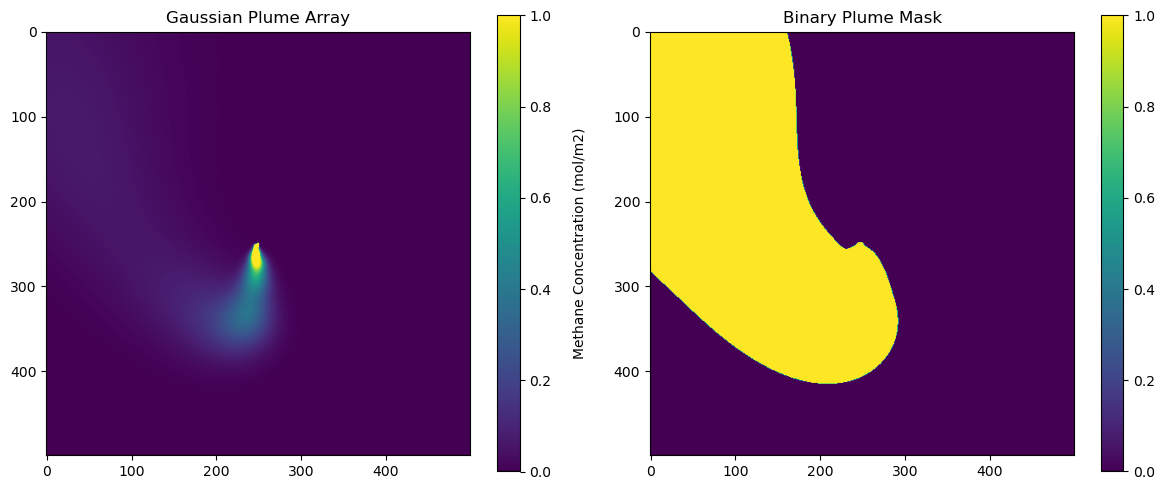

In [8]:
# Define plume mask
plume_binary_mask = gaussian_plume_array > 0.01

# Plot the plume array and mask
plot_synthetic_plume(gaussian_plume_array, plume_binary_mask, vmax=1.0)


#### 1.2 Load Sentinel-2 Tile

For this demo, we use **Sentinel-2 Level-1C imagery**, which is publicly available via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/) or accessed more conveniently via Microsoft's **Planetary Computer**. Our workflow leverages **all 13 spectral bands** provided by Level-1C data, ensuring that both methane-sensitive and contextual bands are preserved during processing.

In the main [`methane-cv`](https://github.com/Orbio-Earth/methane-cv) repository, the Sentinel-2 imagery preprocessing pipeline is implemented in  
[`sentinel2`](https://github.com/Orbio-Earth/methane-cv/blob/main/src/data/sentinel2_l1c.py#:~:text=sentinel2.py-,sentinel2_l1c,-.py). This module handles tile downloading, cropping, rescaling, and metadata extraction. For this notebook, we’ve pre-downloaded the imagery and cropped it into **500×500 pixel tiles** — a size chosen to align with our internal tiling grid. That said, the method is flexible and works with tiles of arbitrary dimensions.

To simulate realistic methane absorption, the pipeline also requires **solar and observation angles**:
- **Solar angles** (zenith & azimuth) describe the sun’s position relative to the pixel.
- **Viewing angles** describe the satellite sensor’s orientation.

These values are embedded in the XML metadata that comes with each Sentinel-2 download and are essential for accurate radiative transfer modeling.

> 🔍 **Note:** For simplicity, this demo uses a pre-cropped tile with **hardcoded metadata values**. If you're generating a full dataset, you'll need to extract these parameters dynamically from the XML metadata, as done in the full codebase.


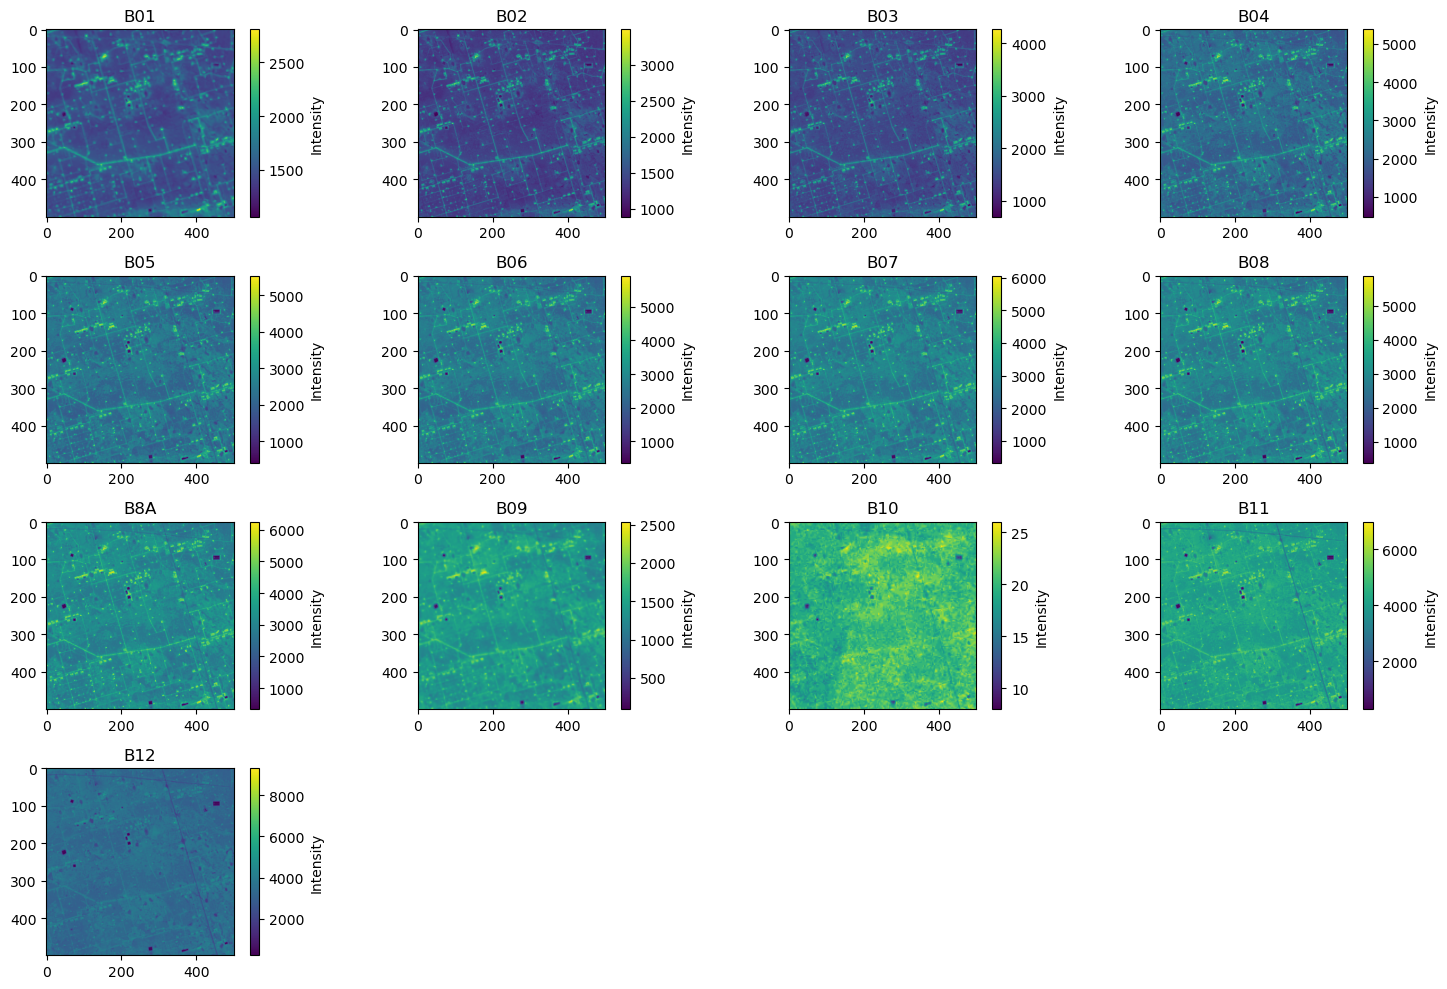

In [9]:
# Load an example Sentinel-2 (preprocessing level 1C) tile stack with all 13 bands
s2_tile_stack = np.load('resources/data_generation/tile_stack.npy')

# Define tile metadata, this is currently hardcoded but available in the sentinel-2 tile metadata XML file
solar_angle = 53.67
observation_angle = 9.98

# Plot the Sentinel-2 bands
fig = plot_multiband_array(
    array_stack=s2_tile_stack,
    titles=S2Band.get_band_list(),
    figsize=(15, 10),
    cmap='viridis'
)




### 2. Calculate Normalised brightness

#### 2.1 Load Atmospheric Data

As previously mentioned, atmospheric absorption constants are obtained from the **[HAPI](https://hitran.org/hapi/) (HITRAN Application Programming Interface)** dataset. We use the notebook  
`radtran/radtran/utils/hapi_utils/hapi_fetcher.ipynb`  
to fetch and preprocess the relevant HAPI data for use in the radiative transfer calculations.

To use this workflow with your own satellite platform, you'll need to obtain the **spectral response functions** for the instrument in question. These functions describe how each satellite band responds to different wavelengths of incoming light. Additionally, you will have to edit the 'radtran/radtran/utils/hapi_utils/satellite_params.json' file for your given satellite. At present, the parameter file contains parameters for Sentinel-2 (A,B and C), Landsat 8 and 9, EMIT and GEOS.

> ✅ For your convenience, we’ve already included the **Sentinel-2 spectral response functions** required to run this demo.


In [10]:
B11_tile = s2_tile_stack[S2Band.get_band_index("B11")]
B12_tile = s2_tile_stack[S2Band.get_band_index("B12")]

gamma = get_gamma(solar_angle, observation_angle)

B11_hapi_data = HapiDataFiles(band=S2Band.B11, instrument=Instrument.SENTINEL2A, root_dir=Path("resources/data_generation/atmospheric_radtran_data"))

B12_hapi_data = HapiDataFiles(band=S2Band.B12, instrument=Instrument.SENTINEL2A, root_dir=Path("resources/data_generation/atmospheric_radtran_data"))


#### 2.2 Insert Sythetic Methane Plume with Radtran

As previously described, we insert the simulated Gaussian plume into the Sentinel-2 tile using the **radiative transfer (radtran)** functions discussed earlier. These functions allow us to realistically modify the spectral values of the image to reflect methane absorption at each pixel.

In the main [`methane-cv`](https://github.com/Orbio-Earth/methane-cv) codebase, this functionality is split across several modules:

- **Radiative transfer logic:**  
  [`Radtran Utils`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/utils#:~:text=quantification_utils.py-,radtran_utils,-.py)

- **Plume insertion logic:**  
  [`Sim Plumes`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/common#:~:text=data_item.py-,sim_plumes,-.py)`

- **Overall data generation orchestration:**  
  [`Data Item`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/common#:~:text=__init__.py-,data_item,-.py)

This notebook demonstrates the core logic in a simplified form. However, the full pipeline in the repo includes **several important additional steps** to ensure quality and realism:

#### 🔄 Transformations
Before insertion, we apply a series of transformations to the simulated plumes:
- Random **flips** and **rotations**
- **Resampling** to match the spatial resolution of the target satellite, if needed

These transformations are handled by the function:  
[`transform_and_position_plumes`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/common#:~:text=last%20week-,sim_plumes.py,-First%20dump)

#### ☁️ Cloud and Water Masking
To avoid placing plumes in non-relevant areas:
- We use **OmniCloud** for cloud detection to avoid inserting plumes over clouds.
- Similarly, we apply masks using the **Sentinel-2 Level-2A Scene Classification Layer (SCL band)** to exclude **NODATA** and **water bodies** when randomly positioning plumes within the tile.

These filtering steps help ensure the simulated methane events appear in realistic, cloud-free land regions, improving both visual plausibility and training effectiveness.

> ⚠️ **Note:** For simplicity, these advanced steps are not included in this notebook demo, but they are essential for large-scale dataset generation and are fully implemented in the main repository.


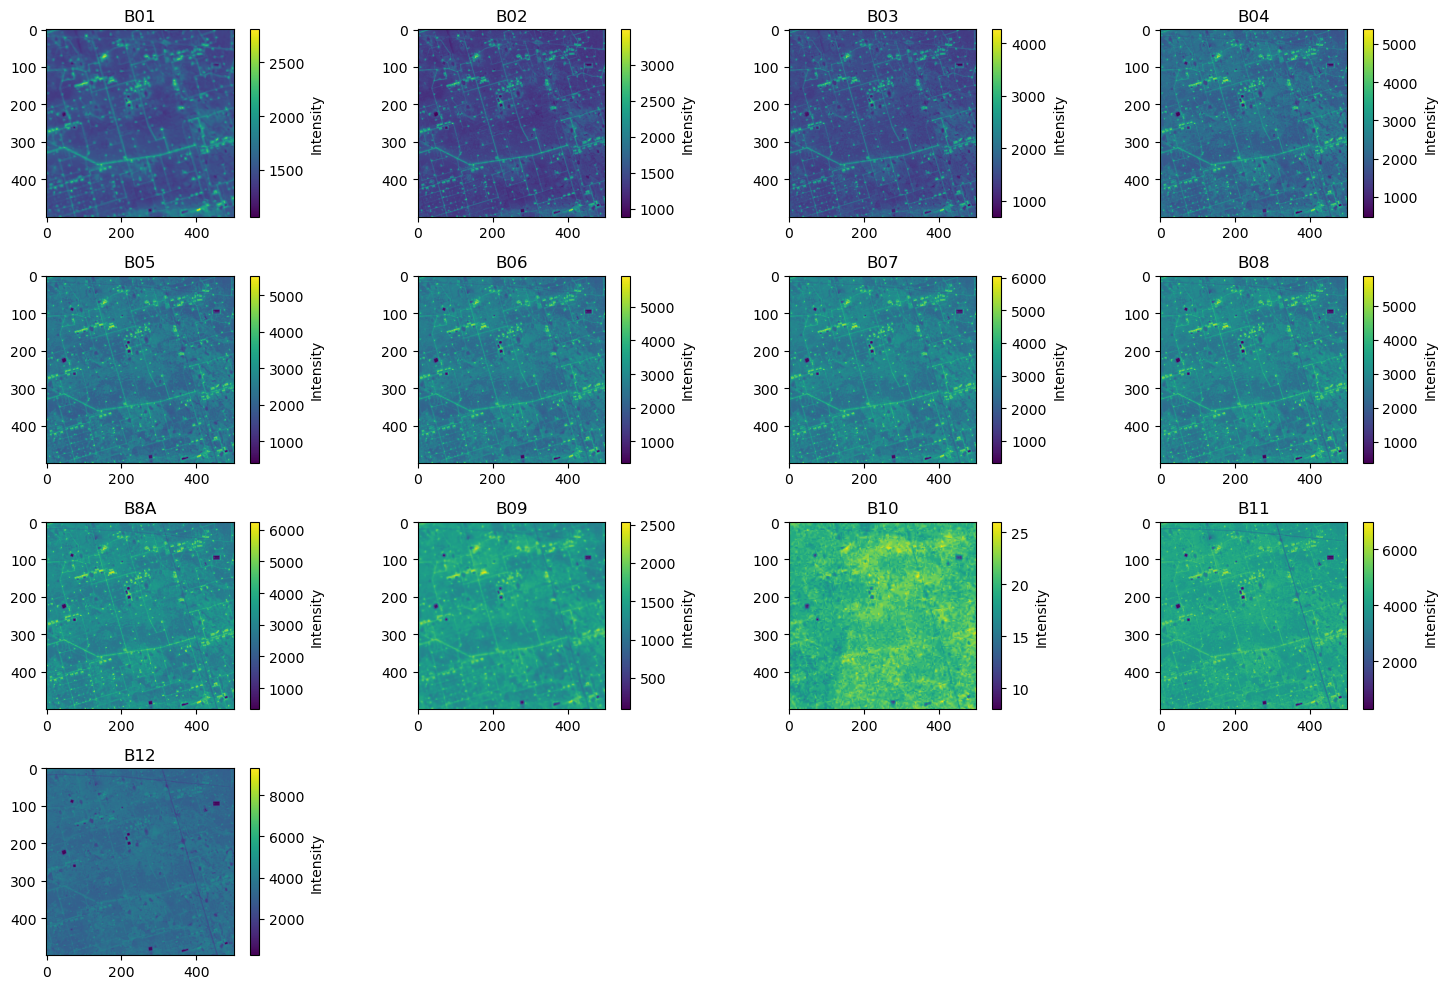

In [11]:
B11_global_filter = generate_global_filter(B11_hapi_data, gamma)
B12_global_filter = generate_global_filter(B12_hapi_data, gamma)

_, norm_brightness_grid_B11 = radtran(gamma, B11_global_filter, B11_hapi_data)
_, norm_brightness_grid_B12 = radtran(gamma, B12_global_filter, B12_hapi_data)



nB_B11 = lookup_nB(gaussian_plume_array, norm_brightness_grid_B11)
nB_B12 = lookup_nB(gaussian_plume_array, norm_brightness_grid_B12)

sim_B11 = nB_B11 * B11_tile.squeeze()
sim_B12 = nB_B12 * B12_tile.squeeze()

sim_tile_stack = s2_tile_stack.copy()
sim_tile_stack[S2Band.get_band_index("B11")] = sim_B11
sim_tile_stack[S2Band.get_band_index("B12")] = sim_B12

# Plot the Sentinel-2 bands
fig = plot_multiband_array(
    array_stack=sim_tile_stack,
    titles=S2Band.get_band_list(),
    figsize=(15, 10),
    cmap='viridis'
)







##### 🔍 Visualizing the Inserted Plume in Sentinel-2 Bands

Once inserted into the Sentinel-2 tile, the synthetic methane plume primarily affects **Band 11 (SWIR1)** and **Band 12 (SWIR2)**, the two bands sensitive to methane absorption. 

Among these, **Band 12** shows a stronger response, as it overlaps more significantly with methane absorption features. This makes the plume generally **more visible in Band 12** than in Band 11. However, the visibility of the plume can vary depending on:

- The **emission rate** used in the simulation
- The **background variability** and **land cover** of the tile (e.g., urban vs. desert vs. forest)
- Atmospheric noise and sensor resolution

In some cases , especially over textured or noisy surfaces, the plume may be difficult or even impossible to spot with the naked eye in raw band data.

To improve visibility and highlight methane signal contrast, we use the **B12/B11 band ratio**. This technique enhances subtle absorption differences and provides a clearer visual representation of the plume's footprint.

> 💡 **Tip:** Try plotting the B12/B11 ratio as a grayscale or colormapped image , it's one of the easiest ways to quickly confirm that the plume was successfully inserted.


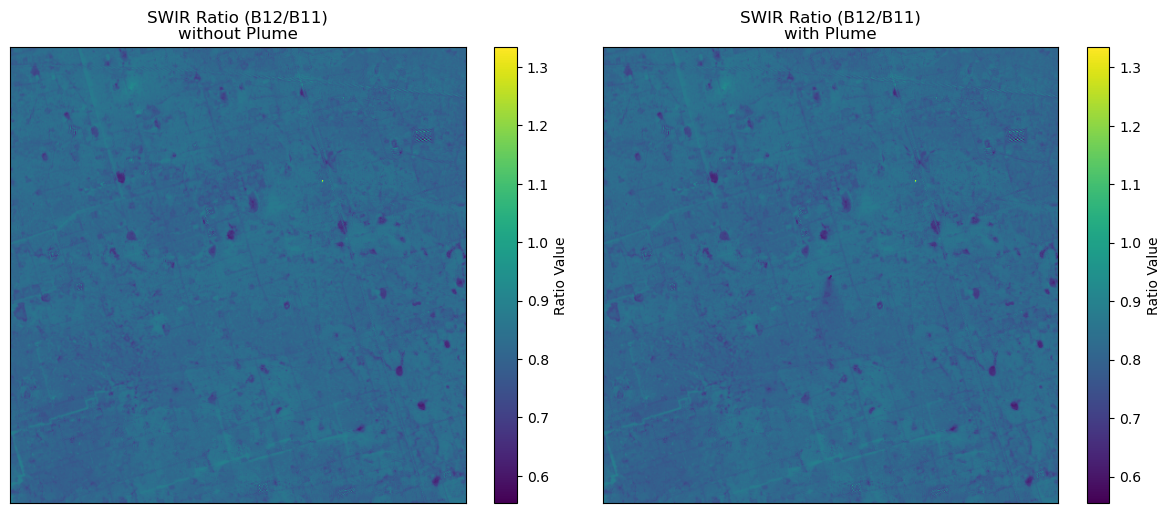

In [ ]:

swir_ratio = s2_tile_stack[S2Band.get_band_index("B12")]/s2_tile_stack[S2Band.get_band_index("B11")]
swir_ratio_with_plume = sim_tile_stack[S2Band.get_band_index("B12")]/sim_tile_stack[S2Band.get_band_index("B11")]

plot_ratios(swir_ratio, swir_ratio_with_plume)




### 🧩 Addendum: Creating the Full Training Dataset Using the [`methane-cv`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/common#:~:text=/-,methane%2Dcv,-Type) Repository

The full training dataset can be generated using a pipeline defined in the main [`methane-cv`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/common#:~:text=/-,methane%2Dcv,-Type) repository. This process is designed to run as an Azure job, and is launched via:

[`Run Data Generation`](https://github.com/Orbio-Earth/methane-cv/tree/main/src#:~:text=azure_run_data_generation)


You can explore the available options using:

```bash
python azure_run_data_generation.py --help
```

Most parameters, such as tile sources, crop size, number of plumes per tile, and more, are configured via Hydra configuration files located at:

[`Config`](https://github.com/Orbio-Earth/methane-cv/tree/main/src#:~:text=utils.py-,config,-generation)

The Azure runner script internally calls:

[`Generate`](https://github.com/Orbio-Earth/methane-cv/tree/main/src#:~:text=emit_data.py-,generate,-.py)

Which then dispatches to the appropriate satellite-specific generation module based on the selected configuration:

Sentinel-2:
[`Sentinel2`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation#:~:text=landsat.py-,sentinel2,-.py)

Landsat:
[`Landsat`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation#:~:text=emit_generation.py-,landsat,-.py)

EMIT:
[`EMIT`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation#:~:text=base.py-,emit_generation,-.py)

Each of these modules handles satellite-specific logic such as downloading imagery, cropping tiles, and preparing metadata. They all ultimately call:

[`Data Item`](https://github.com/Orbio-Earth/methane-cv/tree/main/src/data/generation#:~:text=data_item-,.,-py)

This final module constructs the **individual training tiles**, each containing:
- An aligned satellite image  
- An inserted methane plume  
- Associated metadata  
- Optional masks (e.g., cloud or water masks)

> 💡 **Tip:** This full pipeline is robust and modular, making it easy to extend to new satellites or alternate configurations using




### 📚 References

- Dean, C. L. (2015). *Efficient MCMC inference for remote sensing of emission sources* (Doctoral dissertation, Massachusetts Institute of Technology).  
- Gorroño, J., Varon, D. J., Irakulis-Loitxate, I., & Guanter, L. (2023). Understanding the potential of Sentinel-2 for monitoring methane point emissions. *Atmospheric Measurement Techniques*, 16(1), 89–107.  
- Varon, D. J., Jervis, D., McKeever, J., Spence, I., Gains, D., & Jacob, D. J. (2020). High-frequency monitoring of anomalous methane point sources with multispectral Sentinel-2 satellite observations. *Atmospheric Measurement Techniques Discussions*, 2020, 1–21.
